## Load data

In [3]:
import sys
import os
import pandas as pd
import numpy as np
sys.path.insert(0, os.path.abspath(os.path.join(os.path.curdir, '..', 'src')))

dataset_path = '../dataset/unc-dr_aie.h5'
with pd.HDFStore(dataset_path, mode='a') as store:
    print("Loading cached data...")
    for i, subdf in store['fc_data'].groupby('CellID', observed=True):
        if i == 0:
            df = subdf[['SubjectID', 'Pretreatment', 'Sex']].reset_index(drop=True)
    subjs = df['SubjectID'].unique()
    zstacks = []
    for i, subj in enumerate(subjs):
        corr_df = store[f"{subj.replace('-', '_')}/corr"]
        df_clipped = corr_df.clip(lower=-0.999999, upper=0.999999)
        df_z = df_clipped.map(np.arctanh).to_numpy()
        if i == 0:
            indice = np.tril_indices_from(df_z, k=-1)
        zstacks.append(df_z[indice])
zarray = np.stack(zstacks, 0)

Loading cached data...


## OLS fitting

In [4]:
from camri.stats.model.ols import OLS

df['Sex'] = pd.Categorical(df['Sex'], categories=['Female', 'Male'], ordered=True)

model = 'Fisher_z ~ C(Pretreatment, Treatment(reference="Water")) * C(Sex, Sum)'
model_est = OLS(model, df=df, y=zarray)
model_est.fit()

### Statsmodels 

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_sub = df.copy()
df_sub['Fisher_z'] = zarray[:, 0]
lm = ols(model, data=df_sub).fit()
sm.stats.anova_lm(lm, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,20.337391,1.0,249.790432,4.898356e-18
"C(Pretreatment, Treatment(reference=""Water""))",0.009512,1.0,0.116835,7.344268e-01
"C(Sex, Sum)",0.140762,1.0,1.728886,1.966449e-01
"C(Pretreatment, Treatment(reference=""Water"")):C(Sex, Sum)",0.002813,1.0,0.034548,8.535608e-01
Residual,3.012459,37.0,NaN,NaN


In [ ]:
from camri.stats.inference.anova import Anova

anova = Anova(model_est, typ="III")
anova.fit()
sm = anova.summary()
results = {
    'terms': list(sm['terms']) + ['Residual'],
    'sum_sq': list(sm['ss_terms'][:, 0]) + [sm['ss_resid'][0, 0]],
    'df': list(sm['df_terms'][:, 0]) + [sm['df_resid']],
    'F': list(sm['f_values'][:, 0]) + [np.nan],
    'PR(>F)': list(sm['p_values'][:, 0]) + [np.nan]
}
pd.DataFrame(results)

,terms,sum_sq,df,F,PR(>F)
0,Pretreatment,0.009512,1,0.116835,0.734427
1,Sex,0.140762,1,1.728886,0.196645
2,Pretreatment:Sex,0.002813,1,0.034548,0.853561
3,Residual,3.012459,37,NaN,NaN


In [12]:
from scipy.stats import t
def contrast_t_test(model, contrast):
    """
    Compute T-statistics and two-tailed p-values for a given linear contrast on a fitted OLS model.

    Parameters
    ----------
    model : OLS
        A fitted OLS model instance with attributes:
        - X_: design matrix (n_samples, n_features)
        - intercept_: array of shape (1, n_targets)
        - coef_: array of shape (n_features-1, n_targets)
        - resid: array of shape (n_samples, n_targets)
        - statistics_["dof"]["error"]: residual degrees of freedom
    contrast : array_like, shape (n_features,)
        Row vector specifying the linear contrast R of length equal to n_features.

    Returns
    -------
    t_vals : ndarray, shape (n_targets,)
        T-statistics for each target/voxel.
    p_vals : ndarray, shape (n_targets,)
        Two-tailed p-values for each target.
    """
    # Design matrix and residuals
    X = model.X_
    resid = model.resid
    df_resid = model.statistics_["dof"]["error"]

    # Stack intercept and coefficients -> shape (n_features, n_targets)
    beta = np.vstack([model.intercept_, model.coef_])

    # Residual variance for each target
    scale = np.sum(resid**2, axis=0) / df_resid  # shape (n_targets,)

    # Compute covariance of beta: (X^T X)^-1
    XtX_inv = np.linalg.pinv(X.T @ X)  # shape (n_features, n_features)

    # Numerator: R @ beta -> shape (n_targets,)
    num = contrast @ beta  # shape (n_targets,)

    # Denominator: sqrt(scale * R @ (X^T X)^-1 @ R^T)
    var = contrast @ XtX_inv @ contrast.T  # scalar
    se = np.sqrt(scale * var)  # shape (n_targets,)

    # T-statistics and two-tailed p-values
    t_vals = num / se
    p_vals = 2 * (1 - t.cdf(np.abs(t_vals), df_resid))

    return t_vals, p_vals

In [ ]:
r = np.zeros(4)
# Ethanol - Water | Female [0, 1, 0, 1]
r_ = r.copy()
r_[1] = 1
r_[3] = 1

# Ethanol - Water | Male [0, 1, 0, -1]
r_ = r.copy()
r_[1] = 1
r_[3] = -1

# Female - Male | Water    [0, 0, 1, 0]
r_ = r.copy()
r_[2] = 1

# Female - Male | Ethanol  [0, 0, 1, 1]
r_ = r.copy()
r_[2] = 1
r_[3] = 1

In [16]:
def generate_linear_data(n=100, noise=0.0, multi=False):
    """
    Create a simple linear dataset: y = 2 + 3*x + noise.
    If multi=True, returns two targets with different slopes.
    """
    np.random.seed(0)
    x = np.linspace(0, 1, n)
    y_base = 2 + 3 * x + noise * np.random.randn(n)
    df = pd.DataFrame({'x': x})
    if not multi:
        y = y_base.reshape(-1, 1)
    else:
        # Second target: y2 = 1 + 4*x
        y2 = 1 + 4 * x + noise * np.random.randn(n)
        y = np.vstack([y_base, y2]).T
    return df, y

In [7]:

df, y = generate_linear_data(n=50, noise=0.0)
model = 'y ~ x'
ols = OLS(model, df, y, fit_intercept=True)
# fitted = ols.fit()

# Check intercept and slope
# assert np.allclose(fitted.intercept_, [[2.0]], atol=1e-6)
# assert np.allclose(fitted.coef_, [[3.0]], atol=1e-6)

# # Predictions match true values exactly
# y_pred = fitted.predict()
# assert y_pred.shape == y.shape
# assert np.allclose(y_pred, y, atol=1e-6)

# # Residuals are zero for noiseless data
# resid = fitted.resid
# assert np.allclose(resid, np.zeros_like(resid), atol=1e-8)

In [13]:
from patsy.design_info import DesignMatrix
isinstance(ols.X_, DesignMatrix)

True

In [12]:
type(ols.X_)

patsy.design_info.DesignMatrix

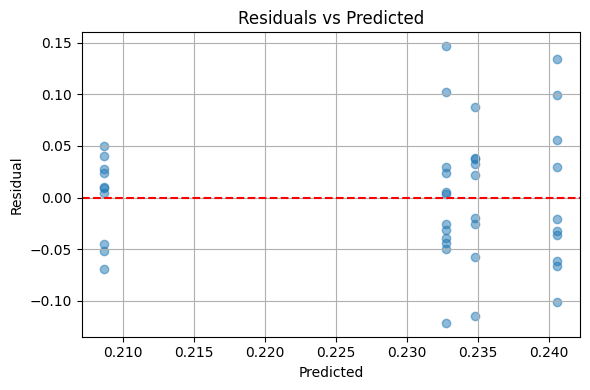

In [ ]:
model_eval.plot_residuals(flatten=False, method="scatter")

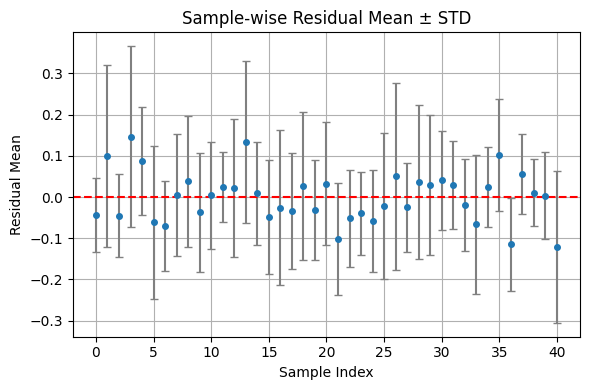

In [ ]:
model_eval.plot_residuals(flatten=False, plot_summary=True)

In [ ]:
model_eval.statistics_